In [1]:
#default_exp dag

In [ ]:
#TODO: port to dask:
# dag class will define the nx and dask graph, will define functions (fit(estimator, X, y), transform(estimator, X)) to be run in
#dask graph. dag building will keep the same interface (with nodes), but node class will be much simpler, since all cache
#handling is done internally in dask graph
# Dask Delayed or Dask Graph? i guess delayed is simpler, just pass object methods inside delayed, and create fit/transform blocks...

In [2]:
#hide
#workaround to make relative imports inside notebook
import sys
sys.path.append('..')

#%load_ext autoreload
#%autoreload 2

# Dependencies

In [69]:
#export
from warnings import warn
from shutil import rmtree
from pathlib import Path
import d6tflow

import networkx as nx
from IPython import display

try:
    import pydot_ng as pydot
except:
    import pydot

from skdag.node import BaseNode, _validate_name, input_task_factory
from skdag.utils import remove_folder_or_file

# PipelineSession
> Session handler to safely serialize objects from pipeline

In [4]:
#export
class PipelineSession():
    '''
    sets d6tflow.settings.dirpath to pipeline name on open
    on close, resets d6tflow.settings.dirpath to default
    '''
    def __init__(self, pipeline_name):
        self.session_name = Path(pipeline_name)
        self.default_name = d6tflow.settings.dirpath
        return
    
    def __enter__(self,):
        d6tflow.settings.dirpath = self.session_name
        return
    
    def __exit__(self, exc_type, exc_value, traceback):
        d6tflow.settings.dirpath = self.default_name
        return

# serialize and deserialize functionalities

In [5]:
#export

def pickle_load(path, **kwargs):
    '''
    abstraction for loading object
    '''
    path = Path(path)
    try:
        with open(path.absolute(), 'rb') as f:
             obj = cloudpickle.load(f, **kwargs)
        
    except Exception as e:            
        raise Exception(f'{str(e)} [{path.absolute()}]')
    
    return obj

def pickle_dump(obj, path, **kwargs):
    '''
    abstraction for dumping objects
    '''
    path = Path(path)
    try:
        with open(path.absolute(), 'wb') as f:
             cloudpickle.dump(obj, f, **kwargs)                            
        
    except Exception as e:            
        raise Exception(f'{str(e)} [{path.absolute()}]')
    
    return


def recursive_dict():
    return defaultdict(recursive_dict)

def undefault_dict(dictionary):
    '''
    recursively transforms a default dicts into dicts
    '''
    for key in dictionary.keys():
        if isinstance(dictionary[key], defaultdict):
            dictionary[key] = undefault_dict(dict(dictionary[key]))
        
        elif isinstance(dictionary[key], dict):
            dictionary[key] = undefault_dict(dictionary[key])
        
        else:            
            return dictionary
    
    dictionary = dict(dictionary)
    return dictionary
            
def recursive_assign(dictionary, keys, value):
    
    '''
    assigns value to dictinary[keys[0]][keys[1]]...[keys[n]] position    
    '''
    
    if len(keys) == 1:
        dictionary[keys[0]] = value
        return dictionary
    
    else:
        dictionary[keys[0]] = recursive_assign(dictionary[keys[0]], keys[1:], value)
    
    return dictionary

def folder_to_dict(root_folder, patterns = ['*.pickle','*.pkl','*.sav']):
    
    '''
    creates a dict of unpickled objects found recursively under root folder and matching patterns
    '''
        
    obj_dict = {}
    root_folder = Path(root_folder)
    
    file_paths = []
    for pattern in patterns:
        file_paths += root_folder.rglob(pattern)
    
    for path in file_paths:        
        obj = pickle_load(path)
        obj_dict[str(path)] = obj
    
    return obj_dict

def dict_to_folder(dictionary, path = '.', assert_new_folder = True, override = False):
    
    '''
    creates folder structure according to dictionary. Can ensure that no folders with the same name 
    are found under path and to raise errors in case the same filenames already exists.
    '''
    root_path = Path(path)
    for key in dictionary:
        
        filepath = Path(key)        
        if assert_new_folder:
            dirpath = root_path/filepath.parts[0]
            if dirpath.exists():
                raise FileExistsError(f'{dirpath.absolute()} already exists.')        
        
        filepath = root_path/filepath
        if filepath.exists():
            if override:
                warn(f'{filepath.absolute()} already exists and will be overriden.')                
            else:
                raise FileExistsError(f'{filepath.absolute()} already exists.')
        
        pickle_dump(dictionary[key], filepath)
            
    return

# graph functionalities

In [6]:
#export
def _traverse_upstream(output_node):  
    '''
    traverses all nodes in the dag that ends at output_node.
    returns nodes and directed edges
    '''
    def __traverse_upstream(node, traversed_nodes = [], traversed_edges = []):
        
        if not isinstance(node, BaseNode):
            raise TypeError(f'Node should be instance of BaseNode, got {type(node)}')
        
        
        traversed_nodes.append(node)
        
        if not isinstance(node, InputTransformer): #keep traversing until reaches an InputNode
            
            for input_node in node.input_nodes:
                traversed_edges.append((input_node, node))
                __traverse_upstream(input_node, traversed_nodes)        

        return traversed_nodes, traversed_edges
    
    traversed_nodes, traversed_edges = __traverse_upstream(output_node)
    return traversed_nodes, traversed_edges

# BaseDag

In [7]:
#export
class BaseDAG(BaseNode):
    pass

#class BaseDAG(BaseNode):
#    '''
#    a base class containing a safe __getattr__ method
#    to ensure that every method and attribute is accessed safely inside 
#    pipeline, i.e. all serialized files are dumped under the same root folder with pipeline name
#    '''
#    
#    def __getattribute__(self, attr):
#        '''
#        returns a wrapped session method or attribute.
#        if attribute is property, opertaions are run safely inside PipelineSession aswell
#        '''        
#        
#        name = super().__getattribute__('name')
#        safe_run = super().__getattribute__('_safe_run')        
#        
#        #safely get attribute value, useful in case attr is property
#        attr_value = safe_run(super().__getattribute__, name)(attr)
#        
#        #case where attribute is method
#        if callable(attr_value):
#            attr_value = safe_run(attr_value, name)
#                    
#        return attr_value
#    
#    def _safe_run(self, method, name):
#        '''
#        runs a method or retrieves an attribute safely inside a PipelineSession
#        '''        
#        
#        def session_wrapped_method(*args, **kwargs):
#            with PipelineSession(pipeline_name = name):                
#                
#                result = method(*args, **kwargs)
#                
#            return result
#
#        return session_wrapped_method                    
        

# Graphviz dot utils

In [8]:
#export
def model_to_dot(graph, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96, subgraph=False, **kwargs):

    
    def add_edge(dot, src, dst):
      if not dot.get_edge(src, dst):
        dot.add_edge(pydot.Edge(src, dst))

    #create dot object
    dot = pydot.Dot()
    dot.set('rankdir', rankdir)
    dot.set('concentrate', True)
    dot.set('dpi', dpi)
    dot.set_node_defaults(shape='record')
    for key in kwargs:
        dot.set(key, kwargs[key])
    

    for node in graph:
        
        if isinstance(node, InputTransformer):
            label = node.name
        else:                                    
            label = f'{{{node.name} | {{{node.__class__.__name__} | {str(node.estimator).split("(")[0]}}} }}'
        
        dotnode = pydot.Node(node.name, label=label)
        dot.add_node(dotnode)
    
    for edge in graph.edges:
        add_edge(dot, edge[0].name, edge[1].name)

    return dot


# DAGEstimator

In [9]:
#export
from sklearn.base import clone
from copy import deepcopy
from sklearn.exceptions import NotFittedError
        

In [26]:
#export
#TODO: define best name for class
class DAGEstimator(BaseDAG):
    
    def __init__(self, output_node, name):        
        
        self.name = _validate_name(name)  
        
        #create node representaitons
        self._make_private_attributes(output_node)             
        self.output_node = [i for i in self.__graph if i.name == f'{self.name}__{output_node.name}'][0]        
        return                                
    
    def _make_private_attributes(self, output_node):
        '''
        creates object private attributes
        '''        
        #node attributes
        graph = self._make_graph(output_node, make_clones = True)
        self.__graph = self._clone_graph(graph)
        #make names with pipename prefix
        [setattr(node, 'name', f'{self.name}__' + node.name) for node in self.__graph]
        self.__nodes = [node for node in self.__graph]
        self.__nodes_dict = {node.name:node for node in self.__graph}
        self.__input_nodes = tuple([i for i in self.__graph if isinstance(i, InputTransformer)])
        self.__input_nodes_dict = {i.name:i for i in self.__graph if isinstance(i, InputTransformer)}        
        
        #palceholders for loaders and tasks
        self.__y_loader = None    
        self.__serializable_artifacts = None
        return
    
    def _clone_graph(self, graph):        
        clones = {}
        for node in nx.algorithms.dag.topological_sort(graph):                        
            clones[node.name] = deepcopy(node)
        
        output_clone = clones[node.name]                                                     
        #replace nodes by its clones
        for node in graph:
            if not isinstance(node, InputTransformer):
                node.input_nodes = [clones[child.name] for child in node.input_nodes]                                    
        
        graph = self._make_graph(output_clone, make_clones = False)
        return graph

    def _populate_folders_unpickle(self):
        '''
        populates dag folders with its serialized objects.
        '''
        return
    
    def _make_graph(self, output_node, make_clones = True):                
        '''
        creates a graph (DAG) traversing output node until reaches inputs
        '''
        
        nodes,edges = _traverse_upstream(output_node)
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)                                
        return g
    
    @property
    def dirpath(self,):
        return d6tflow.settings.dirpath/self.name
    @property
    def nodes(self,):
        return self.__nodes
    @property
    def nodes_dict(self,):
        return self.__nodes_dict
    
    @property
    def graph(self,):
        return self.__graph
    
    @property
    def input_nodes(self,):
        return self.__input_nodes
    
    @property
    def input_nodes_dict(self,):
        return self.__input_nodes_dict
    
    @property
    def y_loader(self,):
        return self.__y_loader                                    
    
    def _reset_data(self,):
        
        '''
        reset input of transform nodes
        '''
                
        #reset inputs and intermediate inputs of transform nodes
        for node in self.nodes:
            if not node.output_path is None:
                #reset input of transform nodes            
                remove_folder_or_file(node.output_path)

        #reset y
        self._reset_y_loader()                                        
        return
    
    def _set_y_loader(self, y):
        '''
        sets y_loader for NodeTransformers (skips InputTransformer)
        '''
        
        if isinstance(y, dict):            
            
            y = {self.name + f'__{k}':v for k,v in y.items()}
            passed_keys = set(y)
            existing_keys = set(self.nodes_dict)
            wrong_passed_keys = passed_keys - existing_keys 
            if wrong_passed_keys:
                raise ValueError(f'Unknown node names: {wrong_passed_keys}')
                
            #create input tasks
            default_loader = input_task_factory(self.name + f'__None', y = None)
            y_loader = {}
            for key in y:        
                y_loader[key] = input_task_factory(f'{key}__target', y = y[key])
            
            for node in self.__graph:
                #if not input node, assign y
                if isinstance(node, NodeTransformer):                
                    if node.name in y_loader:
                        node._set_y_loader(y_loader[node.name])
                    else:
                        node._set_y_loader(default_loader)
                        
        else:
            
            y_loader = input_task_factory(self.name + '__target', y = y)
            for node in self.__graph:
                #if not input node, assign y                
                if isinstance(node, NodeTransformer):                
                    node._set_y_loader(y_loader)
                    
        return

    def _reset_y_loader(self,):
        '''
        resets y_loader for NodeTransformers (skips InputTransformer)
        '''
        try:
            self.y_loader().output().path.unlink()
        except Exception as e:
            warn(str(e))
            pass
                
        return
            
    def _reset_estimators_states(self,):
        '''
        resets states (fitted objects) of nodes in DAG
        '''
        for node in self.nodes:
            if not isinstance(node, InputTransformer):
                if not node.estimator_path is None:                                    
                    remove_folder_or_file(node.estimator_path)
                    

        return
    
    def _check_graph(self,):
        
        if not nx.is_connected(nx.Graph(self.__graph)):
            raise Exception('DAG has disconected parts')
        
        
        if not nx.is_directed_acyclic_graph(self.__graph):
            raise Exception('Infered graph is not a DAG')
        
        
        repeated_names = set(
            [x.name for x in list(self.graph.nodes) if [i.name for i in self.graph.nodes].count(x.name) > 1])
        if repeated_names:
            raise NameError(f'Node names should be unique. Got repeated names: {repeated_names}')
        
        return True    
    
    def _check_X(self, X):
        
        '''
        checks if X is valid input
        '''
        
        if isinstance(X, (tuple, list)):
            if len(X) != len(self.input_nodes):
                raise ValueError(f'DAG has {len(self.input_nodes)} input nodes, got {len(X)} inputs in X')
        
        elif isinstance(X, dict):                        
            if set(X) == set(self.input_nodes_dict):
                raise ValueError(f'DAG input node names are {set(self.input_nodes_dict)}, got {set(X)} keys in X')
        
        else:
            raise TypeError(f'X should be tuple or list of inputs or dict, got {type(X)}')
        
        return
        
    def _populate_input_nodes(self, X):
        '''
        populate input nodes with X passed (list or dict)
        '''
        if isinstance(X, (tuple, list)):
            for idx in range(len(self.input_nodes)):
                
                #TODO: define how to pass **kwargs for each input node
                self.input_nodes[idx].fit(X[idx])
        
        elif isinstance(X, dict):
            for key in range(len(self.input_nodes_dict)):
                self.input_nodes_dict[key].fit(X[key])
                
        else:
            raise TypeError(f'X should be list, tuple or dict, got {type(X)}')
        
        return                    
    
    def _clear_pipeline(self,):
        '''
        removes all cached files in Pipeline folder
        '''
        remove_folder_or_file(self.dirpath)
        return
    
    
    def fit(self, X, y = None, **kwargs):
        
        
        '''
        X must be a list or dict pointing to input Nodes
        '''
        #self._make_graph() why create graph again?        
        self._check_graph()
        #check inputs        
        self._check_X(X)        
        #clear states and data
        self._clear_pipeline()
        #"populate" all nodes with y
        self._set_y_loader(y)        
        #populate input nodes with X
        self._populate_input_nodes(X)                            
        
        #recursively fit output node                            
        self.output_node._fit()        
        return self                
    
    def _infer(self, X, infer_method, reset_cache = True, **kwargs):
        
        '''
        abstract inference method, calls "infer_method" in the final node
        '''
        if reset_cache:
            #reset transform cache
            self._reset_data()

        #populate input nodes with X
        self._populate_input_nodes(X)
        
        #make infer task
        self.output_node._make_transform_task()
        
        #infer             
        out = self.output_node._infer(None, infer_method, **kwargs)        
        return out                
    
    def transform(self, X, **kwargs):
        return self._infer(X, infer_method = 'transform', reset_cache = True, **kwargs)['X']
    
    def sub_dag(self, name):
        '''
        returns a new DAG instance, having its output node defined by name
        '''
        if name == self.name:
            raise NameError('sub_dag name should differ from parent dag name')
        
        return DAGEstimator(self.nodes_dict[name], name)
    
    def make_dot(self, **kwargs):
        '''
        creates a dot object of dag accroding to model_to_dot function
        '''
        return model_to_dot(self.graph, **kwargs)                
    
    def show_dot(self, **kwargs):
        '''
        creates dot file of the dag, prints png and returns dot object
        ''' 
        return display.Image(self.make_dot(**kwargs).create_png())
        
    def _create_states_directory(self,):
        '''
        creates directory with fitted estimators from some dict
        '''
    def __reppr__(self,):
        return self.name
    
    def __getstate__(self,):
        '''
        creates a dictionary with all reference for reconstructing the dag (for serializing purposes)
        '''
        artifacts = {}
        for node in self.nodes:
            if isinstance(node, NodeTransformer):
                artifacts[node.fit_task().output().path] = node.fit_task().output().load()
        
        self.__serializable_artifacts = artifacts
        return self.__dict__
    
    def __setstate__(self, d):
        '''
        creates a dict of objects, with their relative paths as keys , to pickle pipeline
        '''
        self.__dict__ = d
        
        for path in self.__serializable_artifacts:
            #create empty directories
            if not path.parent.exists():
                path.parent.mkdir(parents = True)
            
            if path.exists():
                raise FileExistsError(f'{path.absolute()} already exists.')
            with open(path, 'wb') as f:                
                cloudpickle.dump(self.__serializable_artifacts[path], f)
            
        self.__serializable_artifacts = None
        return
    

## DAGEstimator Usage Example

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from skdag.node import NodeTransformer, InputTransformer, ConcatenateNode
import numpy as np

#custom defined function
from functools import partial
def npsum(axis = 0):     
    return partial(np.sum, axis = axis)

in1 = InputTransformer('Input1')
in2 = InputTransformer('Input2')
in3 = InputTransformer('Input3')


node1 = NodeTransformer(FunctionTransformer(npsum(axis = 0)), [in2,in1], 'prod1')

concat1 = ConcatenateNode([node1,in3], 'Concat1')
node2 = NodeTransformer(LinearRegression(), [concat1], 'model1', transform_method = 'predict')

concat2 = ConcatenateNode([node1,node2,in1, in3],'Concat2')
node3 = NodeTransformer(RandomForestRegressor(), [concat2], 'model2', transform_method = 'predict')

concat3 = ConcatenateNode([node1,node3, in2, in3], 'concat_final')
node4 = NodeTransformer(FunctionTransformer(partial(np.mean, axis = 1)), [concat3], 'sum_final')

In [60]:
X = np.random.randn(1000,3)
y = np.random.randn(1000,)
X = da.from_array(X)

In [54]:
dag = DAGEstimator(node4, 'Pipeline2')

In [55]:
dag.fit([X,X,X], {'model1':y, 'model2':y+100})


===== Luigi Execution Summary =====

Scheduled 16 tasks of which:
* 16 ran successfully:
    - 1 Pipeline2__Concat1__fit()
    - 1 Pipeline2__Concat1__transform()
    - 1 Pipeline2__Concat2__fit()
    - 1 Pipeline2__Concat2__transform()
    - 1 Pipeline2__Input1__input()
    ...

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



Pipeline2

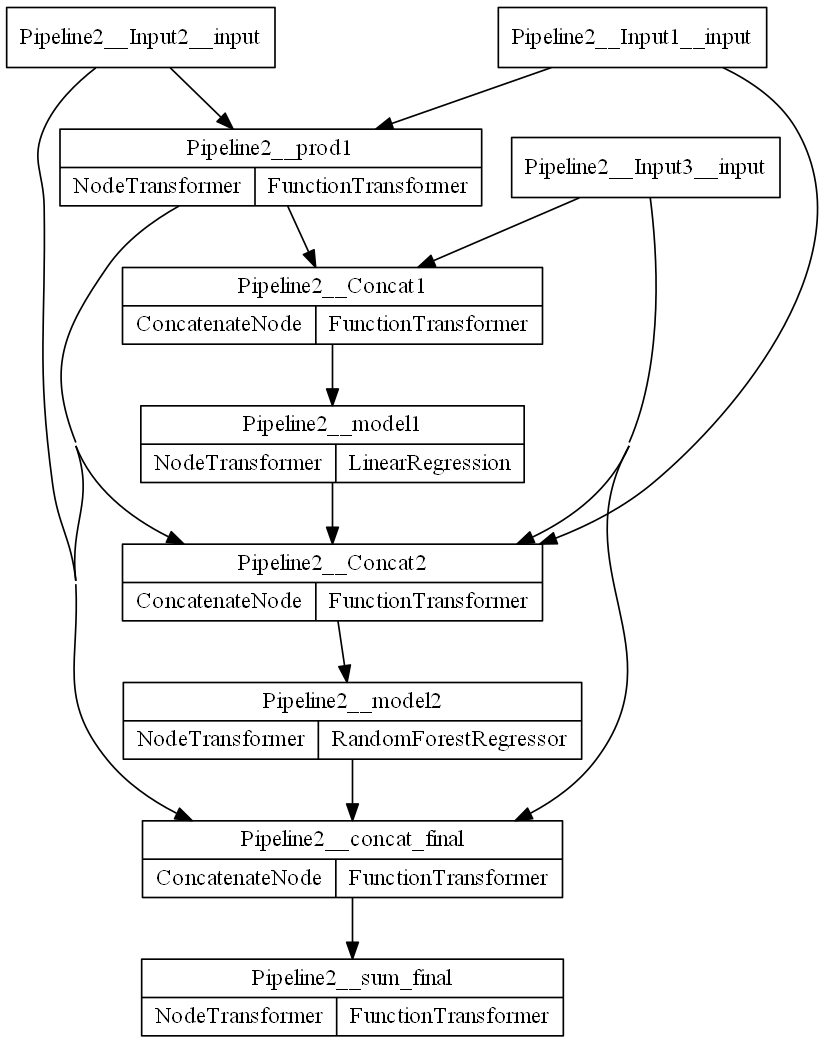

In [56]:
dag.show_dot(dpi = 120)

In [66]:
X = np.random.randn(1000000,3)
results = dag.transform([X,X,X])


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:151: UserWarning: 'NoneType' object is not callable



===== Luigi Execution Summary =====

Scheduled 17 tasks of which:
* 17 ran successfully:
    - 1 Pipeline2__Concat1__fit()
    - 1 Pipeline2__Concat1__transform()
    - 1 Pipeline2__Concat2__fit()
    - 1 Pipeline2__Concat2__transform()
    - 1 Pipeline2__Input1__input()
    ...

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


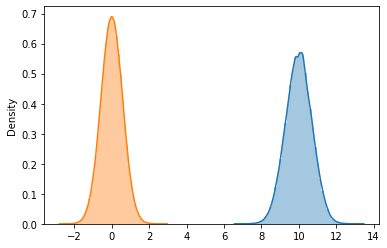

In [67]:
import seaborn as sns
sns.distplot(results)
sns.distplot(X.mean(axis = 1))

# Export

In [68]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted d6tflow-sklearn.ipynb.
Converted dag.ipynb.
Converted node.ipynb.
Converted utils.ipynb.
